In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [4]:
import scanpy as sc

In [5]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')
sys.path.append('/Users/koush/Projects/Banksy_py')
import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 24617 × 3604
    obs: 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
adata.to_df(layer='imputed_count').values.max()

3.673311122529255

In [8]:
%matplotlib inline

In [9]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode_colinks.pkl',
    annot='cell_type_int'
)

In [10]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata, 
    target_gene='Cd74', 
    cluster_annot='cell_type_int',
    radius=200, 
    contact_distance=30,
    grn=co_grn,
)

In [20]:
# estimator.plot_modulators()

In [12]:
estimator.fit(num_epochs=1, learning_rate=5e-3, 
    score_threshold=0.2, l1_reg=1e-9, estimator='lasso')

Fitting Cd74 with 211 modulators
	33 Transcription Factors
	141 Ligand-Receptor Pairs
	37 TranscriptionFactor-Ligand Pairs
0: 0.7881 | 0.8114
1: 0.5803 | 0.7904
2: 0.5154 | 0.8056
3: 0.6414 | 0.7382
4: 0.6317 | 0.8284
5: 0.6376 | 0.8390
6: 0.6511 | 0.7591
7: 0.5084 | 0.7095
8: 0.4068 | 0.7104
9: 0.4484 | 0.7623
10: 0.5388 | 0.7842
11: 0.3826 | 0.7108
12: 0.7167 | 0.7536
13: 0.5340 | 0.7518
14: 0.3513 | 0.7083
15: 0.5433 | 0.7712
16: 0.6232 | 0.8061
17: 0.6542 | 0.7640
18: 0.6190 | 0.7957
19: 0.6218 | 0.7476


: 

In [15]:
adata.obs.drop_duplicates().sort_values('cell_type_int')

cell_type cell_type_int
AAAAAAAACCAACA                   B             0
AAAAATTGCAGTGG          B | CD8+ T             1
AAAGTACCCAAATC              B | DC             2
AAAAAAATTTAGGG       B | Resting T             3
AAACCCTCTAAACG             B | Tfh             4
AAAACGTCGGGATC            B | Treg             5
AAAAAACGTGCGCC              CD8+ T             6
AAACGACAGAGGAG         CD8+ T | DC             7
AAAAAGCGGCGCAC  CD8+ T | Resting T             8
AAAGTGAGGCGAGA        CD8+ T | Tfh             9
AACCTTACTACTTG       CD8+ T | Treg            10
AAAAGATGCTCAGC                  DC            11
AAAAAAAAAAAATC           Resting T            12
AAATAGATCGCCTG  Resting T | CD8+ T            13
AAAAGTATCGGTGG      Resting T | DC            14
AAAACTATTTAAGG     Resting T | Tfh            15
AAACTATCTCTGTT     Resting T | Th2            16
AAAAGCCTACCATG    Resting T | Treg            17
AAACTGGCAGGAGA                 Tfh            18
AAAGCCGACCCCTG                Treg            19

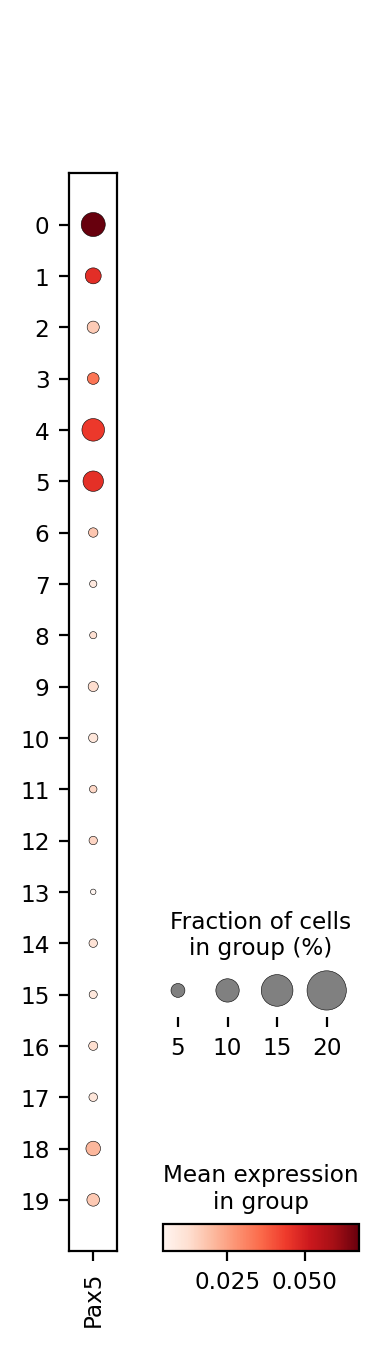

In [19]:
sc.pl.dotplot(adata, groupby='cell_type_int', var_names=['Pax5'])

In [110]:
betadata = estimator.betadata

In [111]:
pd.DataFrame({f'cluster_{i}': estimator.models[i].anchors.cpu().numpy()[1:] 
    for i in range(len(estimator.models))}, index=estimator.modulators).loc['Il6$Il6ra']

cluster_0    0.012020
cluster_1    0.500321
cluster_2   -1.242862
cluster_3    0.107549
cluster_4   -0.089419
cluster_5   -0.001506
cluster_6   -0.594367
Name: Il6$Il6ra, dtype: float32

In [113]:
betadata[betadata.cell_type_int == 0][['x', 'y', 'beta_Il6$Il6ra']].join(estimator.train_df[['Il6$Il6ra']])

x       y  beta_Il6$Il6ra  Il6$Il6ra
AAAAAAAGCCAACA -1255.0  3184.0        0.008111   0.161745
AAAAAACGGTAGAT -4252.0  2626.2        0.007709   0.129165
AAAAACCGTCAGAC -2480.0  1516.6        0.008073   0.185377
AAAAACGCTCCGAC -2764.1  1255.7        0.007988   0.118559
AAAAAGCACGTGTT -3925.9  1618.5        0.008160   0.413299
...                ...     ...             ...        ...
TTTTTTATAATACC -3980.5  2255.0        0.008038   0.126733
TTTTTTGTACGATT -2052.1  2937.7        0.007422   0.059297
TTTTTTTATGGTAC -2631.3  2694.2        0.007886   0.079821
TTTTTTTTATTATA -1936.5  1873.5        0.008106   0.167355
TTTTTTTTGCTTTA -4295.6  2514.8        0.008120   0.119907

[10417 rows x 4 columns]

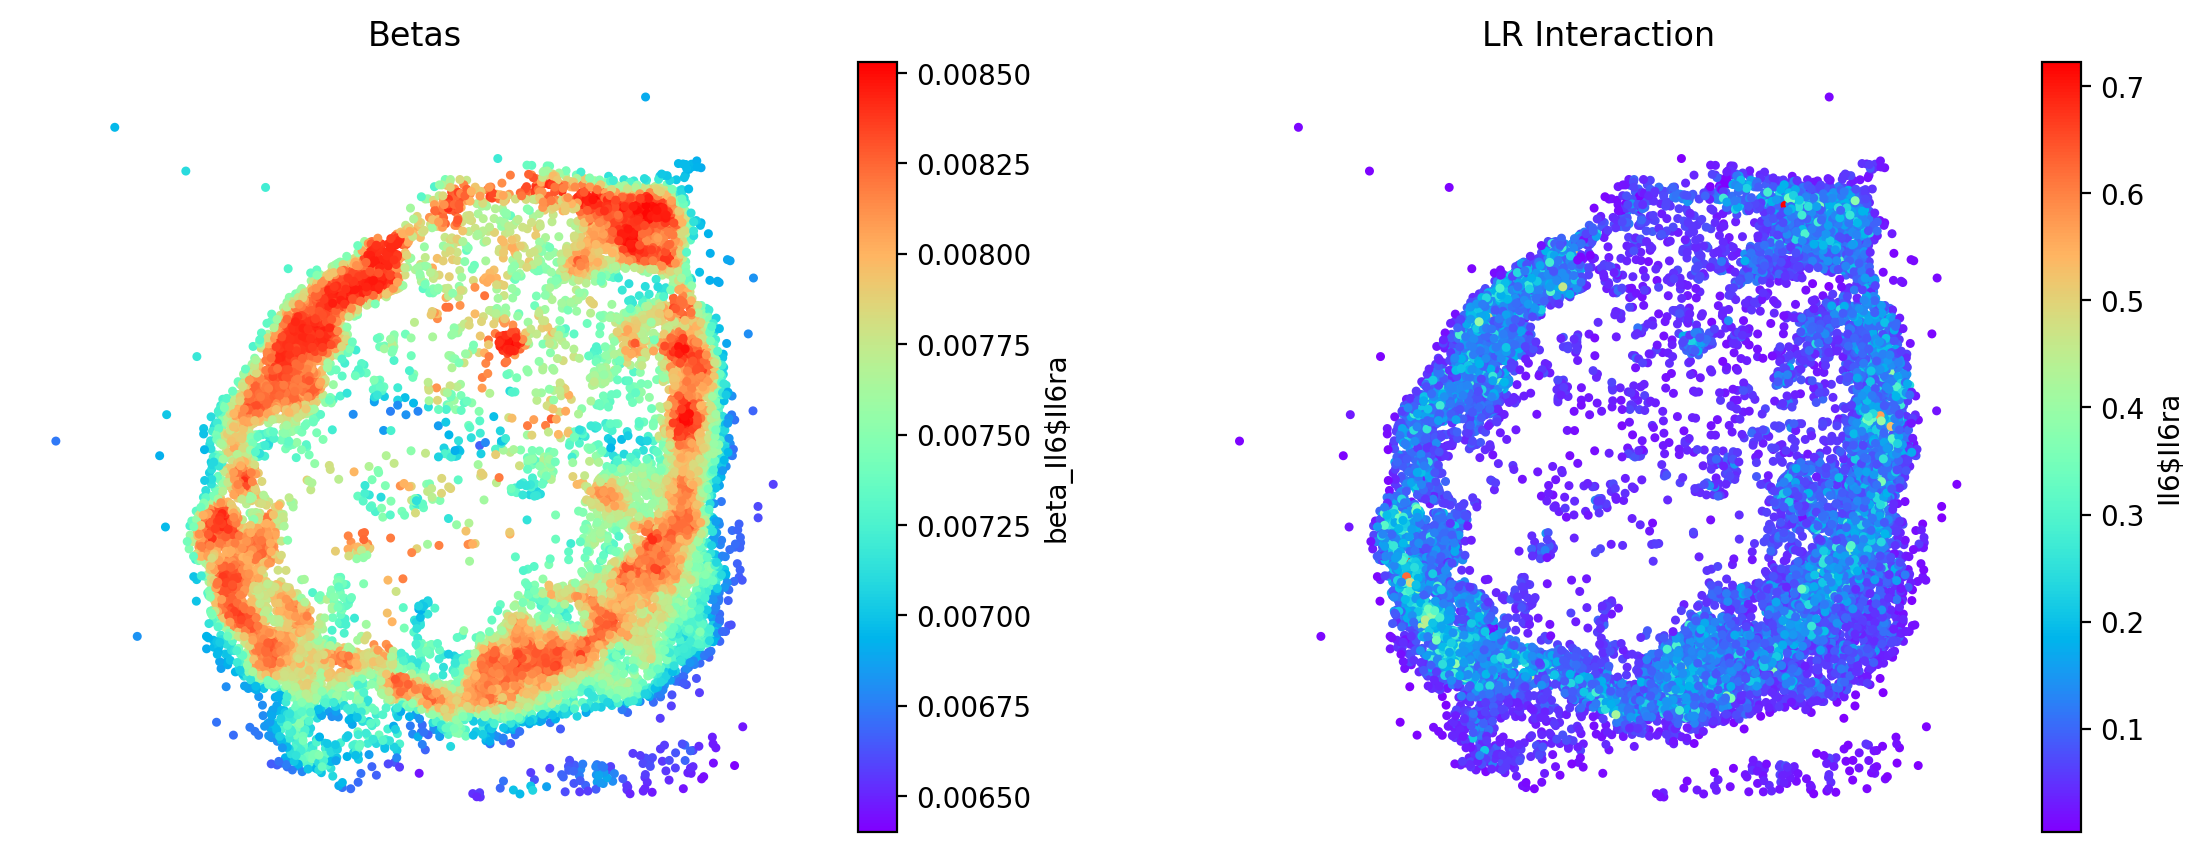

In [115]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
cmap = 'rainbow'
data = betadata[betadata.cell_type_int == 0][
    ['x', 'y', 'beta_Il6$Il6ra']].join(estimator.train_df[['Il6$Il6ra']])


scatter1 = ax[0].scatter(
    data['x'],
    data['y'], 
    c=data['beta_Il6$Il6ra'],
    s=5,
    cmap=cmap
)
f.colorbar(scatter1, ax=ax[0], label='beta_Il6$Il6ra')

scatter2 = ax[1].scatter(
    data['x'],
    data['y'],
    c=data['Il6$Il6ra'],
    s=5, 
    cmap=cmap
)
f.colorbar(scatter2, ax=ax[1], label='Il6$Il6ra')
# Remove ticks and spines
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    for spine in ['top', 'right', 'left', 'bottom']:
        a.spines[spine].set_visible(False)
        
ax[0].set_title('Betas')
ax[1].set_title('LR Interaction')
plt.show()

In [ ]:
sns.scatterplot(data=betadata[betadata.cell_type_int == 0], x='x', y='y', hue='beta_Il6$Il6ra', s=10)

<Axes: ylabel='Frequency'>

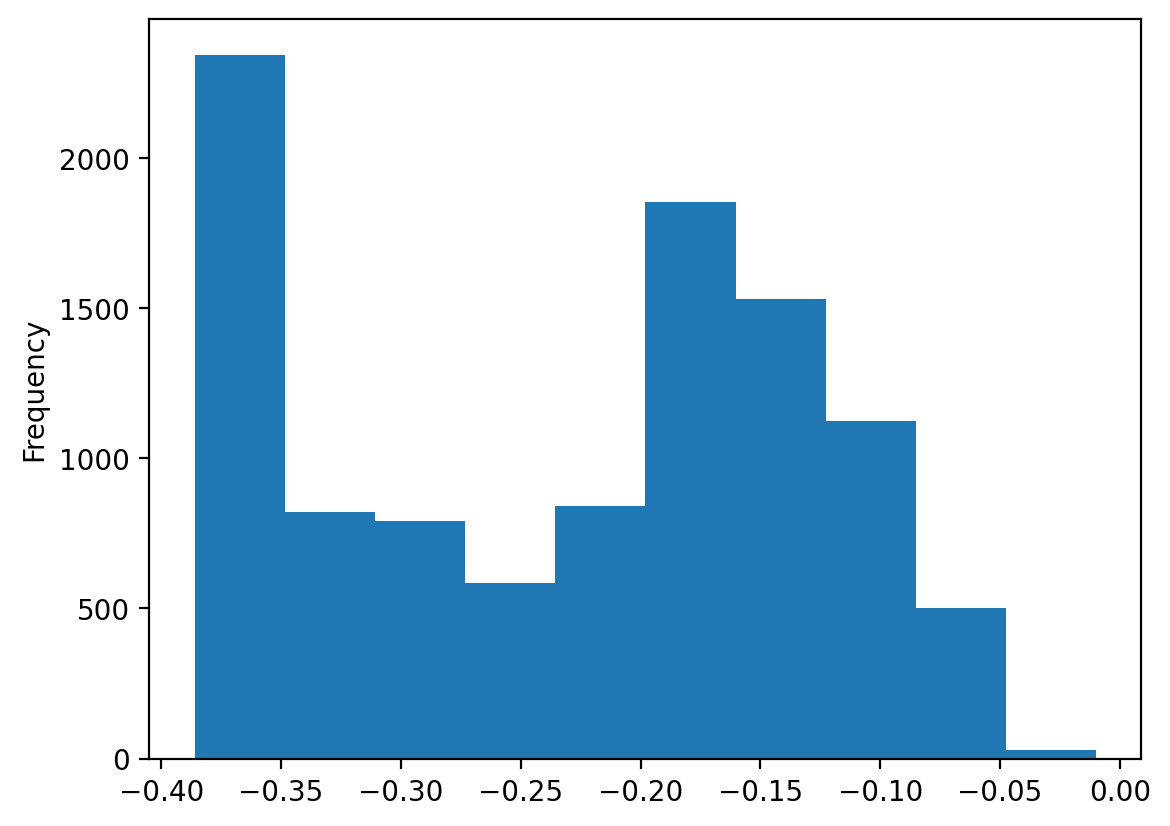

In [59]:
betadata[betadata.cell_type_int == 0]['beta_Il6$Il6ra'].plot.hist()

In [54]:
pd.concat([
    betadata[['cell_type_int', 'beta_Il6$Il6ra']].groupby('cell_type_int').min().rename(columns={'beta_Il6$Il6ra': 'min'}),
    betadata[['cell_type_int', 'beta_Il6$Il6ra']].groupby('cell_type_int').mean().rename(columns={'beta_Il6$Il6ra': 'mean'}),
    betadata[['cell_type_int', 'beta_Il6$Il6ra']].groupby('cell_type_int').max().rename(columns={'beta_Il6$Il6ra': 'max'})
], axis=1)

min      mean       max
cell_type_int                              
0             -0.386102 -0.232888 -0.009840
1             -0.161985 -0.115388 -0.091656
2             -0.714763 -0.483371 -0.300855
3             -0.072208 -0.037466 -0.021878
4             -0.752114 -0.540888 -0.192323
5             -0.163325 -0.100552 -0.026746
6             -0.241936 -0.241886 -0.241440

In [87]:
df_ssh = pd.read_parquet('/Volumes/SSD/mLDN3-1_v4/Cd74_betadata.parquet')

In [32]:
bcols = [i for i in df_ssh.columns if 'beta' in i]

In [33]:
pd.concat([
    df_ssh.drop(columns=['x', 'y']).groupby('cell_type_int').min()[['beta_Il6$Il6ra']].rename(columns={'beta_Il6$Il6ra': 'min'}),
    df_ssh.drop(columns=['x', 'y']).groupby('cell_type_int').mean()[['beta_Il6$Il6ra']].rename(columns={'beta_Il6$Il6ra': 'mean'}),
    df_ssh.drop(columns=['x', 'y']).groupby('cell_type_int').max()[['beta_Il6$Il6ra']].rename(columns={'beta_Il6$Il6ra': 'max'})
], axis=1)

min       mean        max
cell_type_int                                  
0             -158.247833 -66.546143 -19.618738
1               -4.971797  -4.209705  -3.447067
2                0.024030   0.028642   0.032821
3               -0.004619  -0.003487  -0.002221
4               -0.576953  -0.536673  -0.489630
5              -10.355844  -7.955514  -6.598800
6               -0.223042  -0.190984  -0.156876

In [87]:
df_ssh.drop(columns=['x', 'y']).groupby('cell_type_int').mean()[['beta_Il6$Il6ra']]

beta_Il6$Il6ra
cell_type_int                
0                  -66.546143
1                   -4.209705
2                    0.028642
3                   -0.003487
4                   -0.536673
5                   -7.955514
6                   -0.190984

In [88]:
df_ssh.drop(columns=['x', 'y']).groupby('cell_type_int').min()[['beta_Il6$Il6ra']]

beta_Il6$Il6ra
cell_type_int                
0                 -158.247833
1                   -4.971797
2                    0.024030
3                   -0.004619
4                   -0.576953
5                  -10.355844
6                   -0.223042

In [72]:
df_ssh.drop(columns=['x', 'y']).groupby('cell_type_int').max()[['beta_Il6$Il6ra']]

beta_Il6$Il6ra
cell_type_int                
0                  -22.661873
1                  -14.085391
2                   -0.020270
3                   -0.025297
4                   -0.004444
5                   -4.447033
6                   -0.011915

In [67]:
concat = pd.concat([pd.DataFrame(
    estimator.models[i].anchors.cpu().numpy()[1:], 
    index=estimator.modulators) for i in range(7)], axis=1)
concat.columns = range(7)

In [69]:
concat.loc['Il6$Il6ra']


0   -35.618866
1    -4.818295
2    -0.008108
3    -0.014520
4    -0.009709
5   -12.583072
6    -0.014738
Name: Il6$Il6ra, dtype: float32

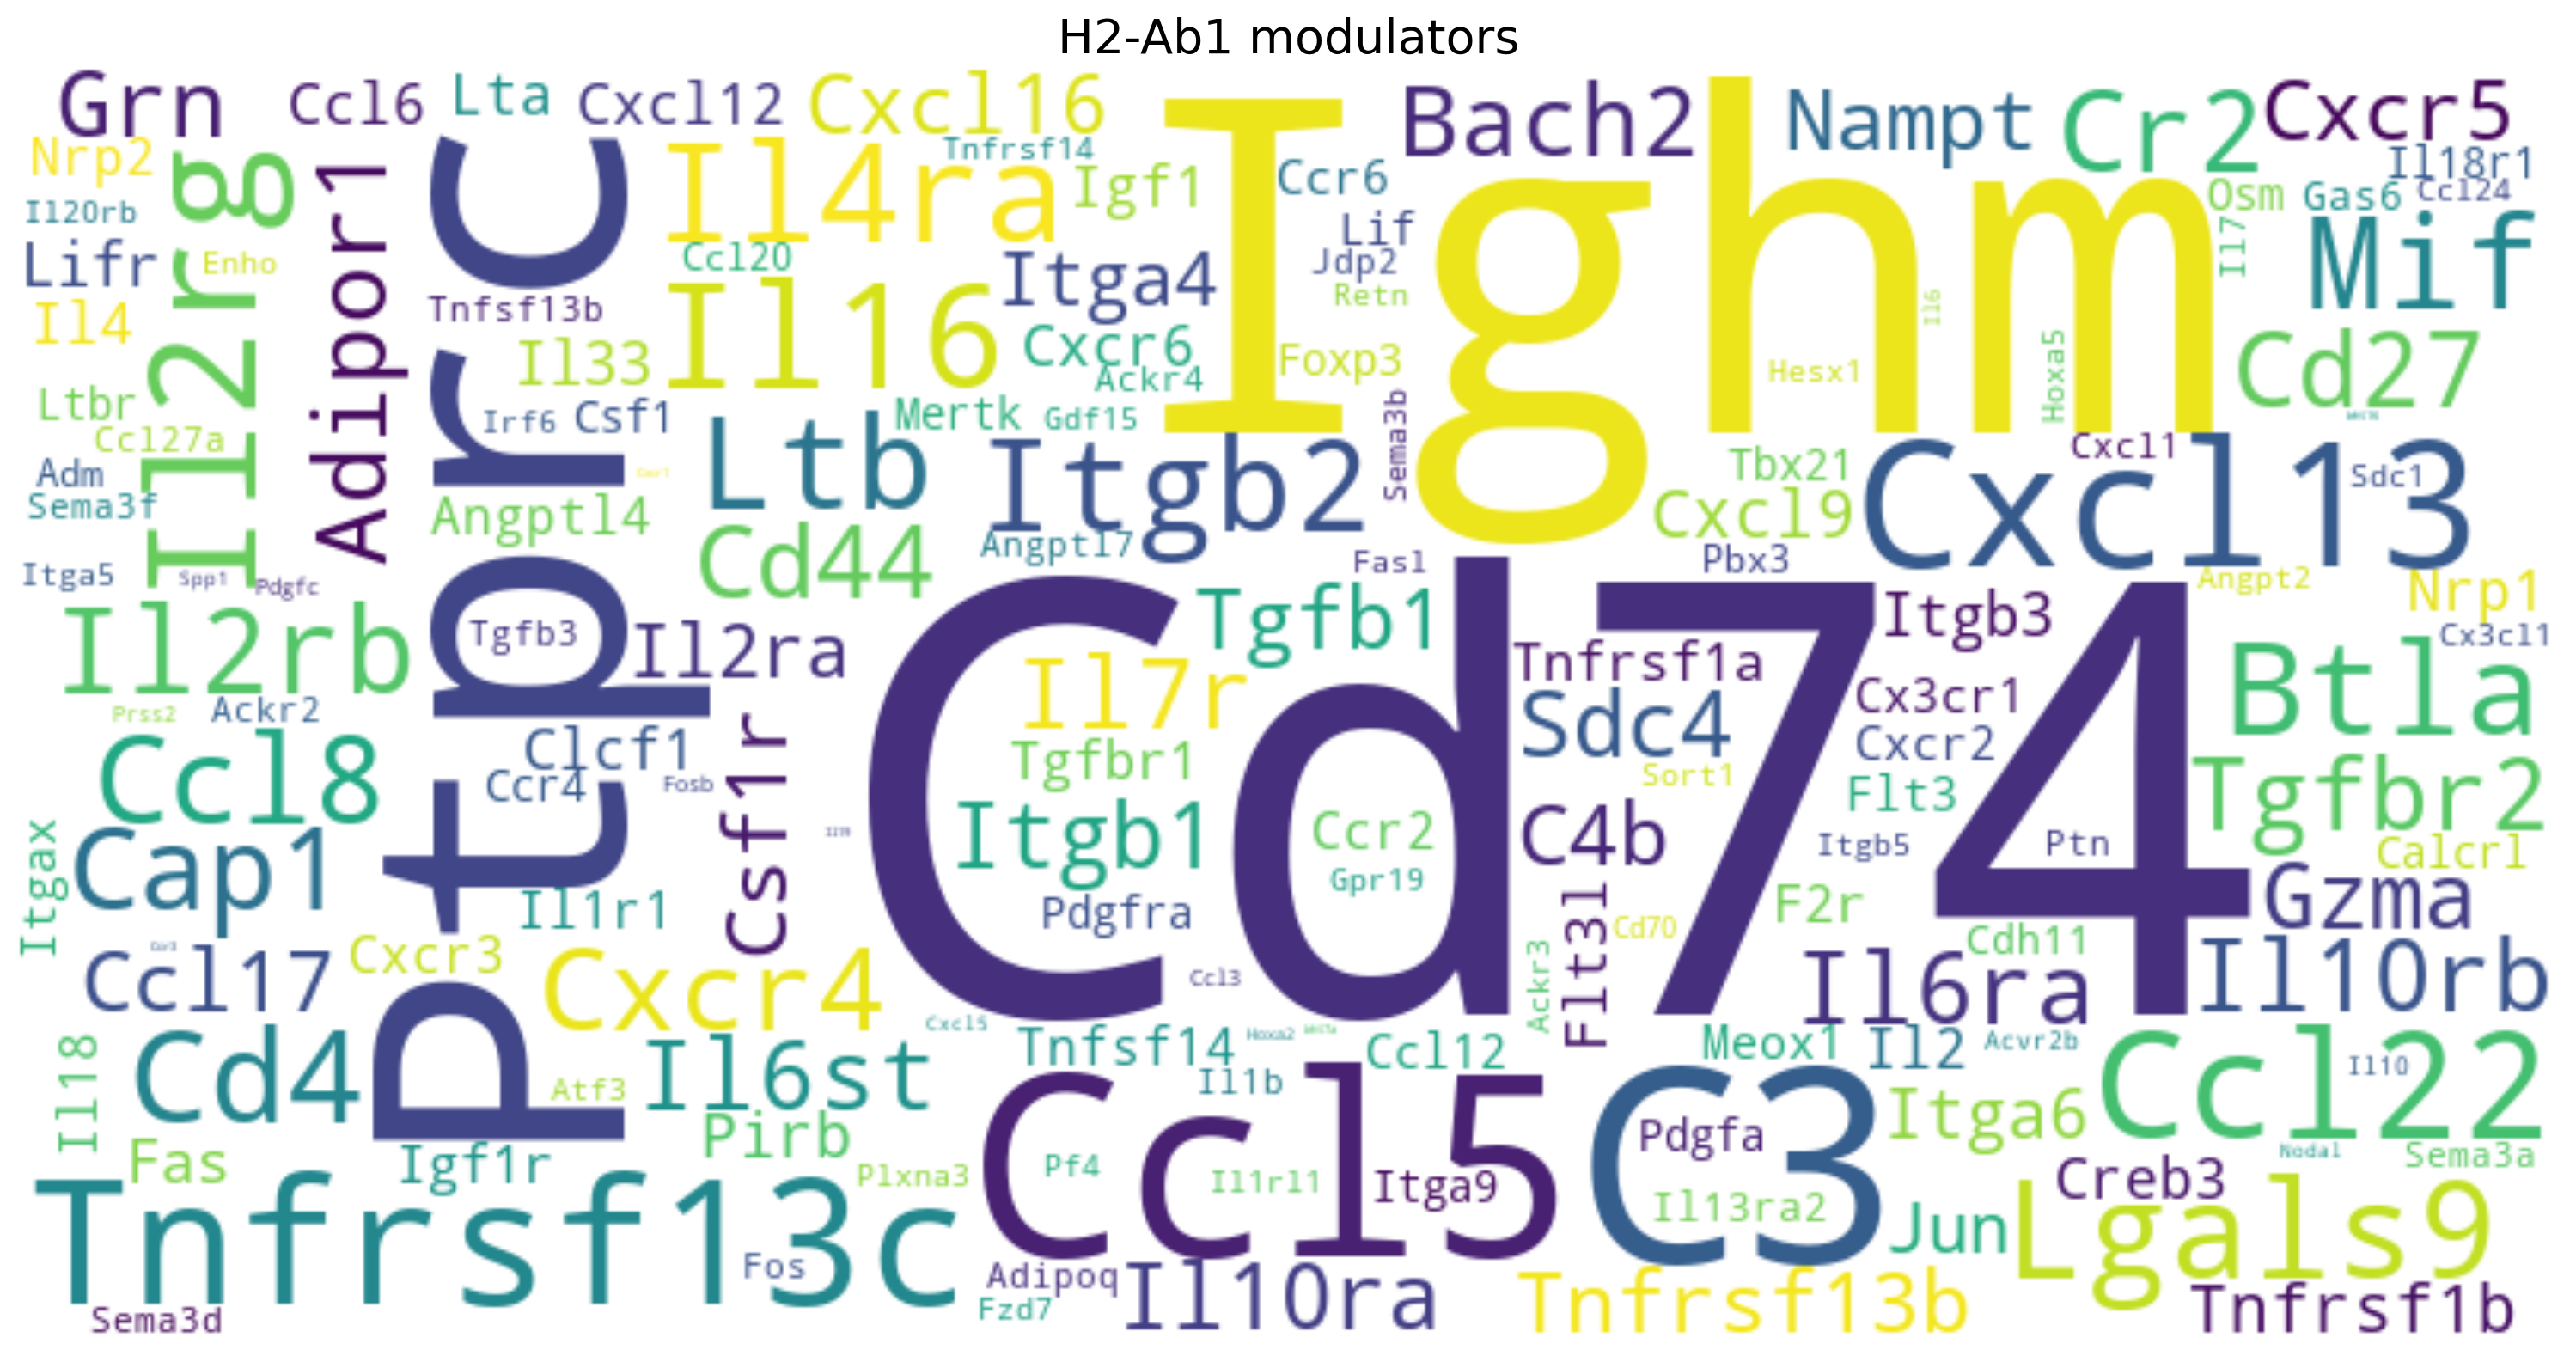

In [67]:
estimator.plot_modulators()

In [35]:
estimator.fit(num_epochs=200, learning_rate=5e-3, score_threshold=0.1)

Fitting H2-Ab1 with 197 modulators
	15 Transcription Factors
	131 Ligand-Receptor Pairs
	51 TranscriptionFactor-Ligand Pairs
0: -0.2658 | 0.7276
1: -1.6482 | 0.7261
2: -1.0132 | 0.5870
3: -3.1952 | 0.5728
4: -3.8713 | 0.6518
5: -2.4635 | 0.7493
6: -1.9123 | 0.5719


In [41]:
pd.DataFrame(estimator.models[0].anchors.cpu().numpy()[1:], index=estimator.modulators)

0
Atf3           14.172355
Bach2          10.452028
Creb3          -0.127455
Fos           -22.544901
Fosb           40.453701
...                  ...
Tgfb1#Tbx21    -6.086395
Il10#Tbx21     -8.965015
Il4#Tbx21      29.166788
Angptl4#Tbx21   9.265828
Il18#Tbx21     13.213453

[197 rows x 1 columns]

In [13]:
betadata = estimator.betadata

In [15]:
beta_cols = [i for i in betadata.columns if 'beta' in i]

In [42]:
betadata[beta_cols].min().sort_values(ascending=False).to_frame()

NameError: name 'betadata' is not defined

<Axes: ylabel='Frequency'>

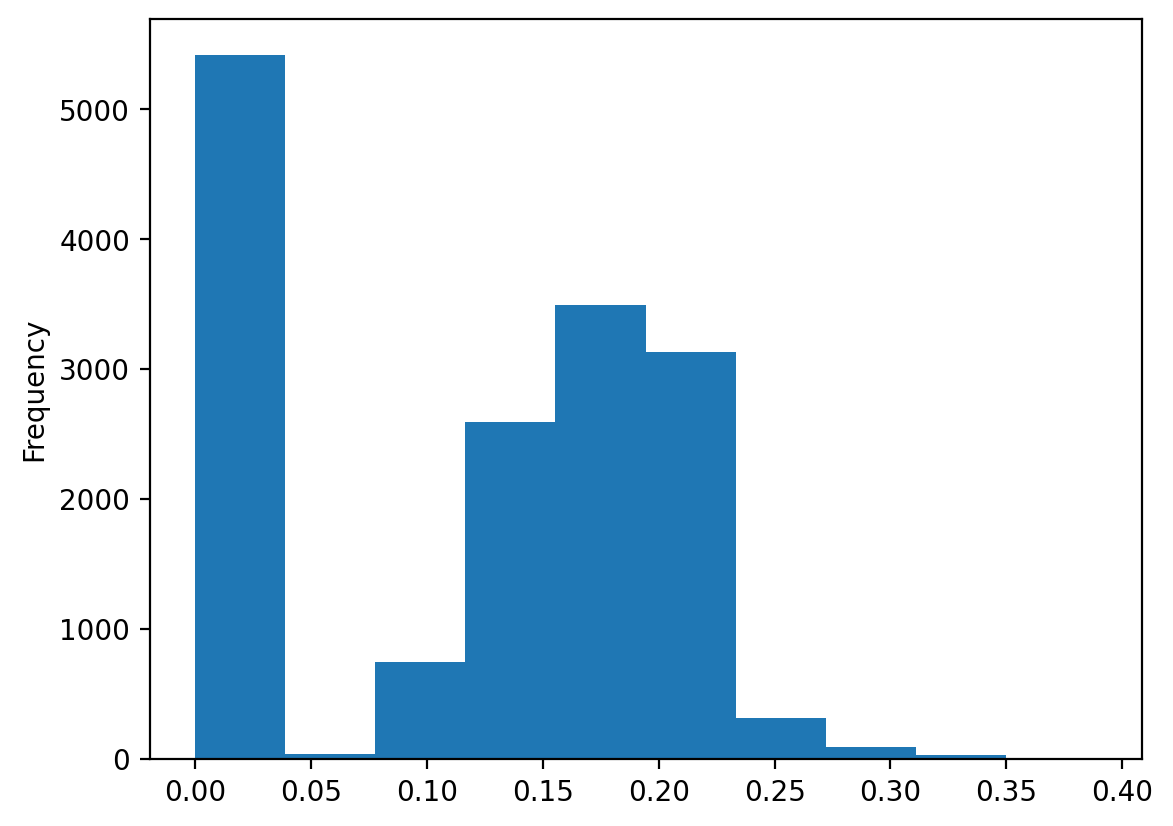

In [24]:
betadata['beta_Spp1$Itgb5'].plot.hist()

In [50]:
_ = estimator.init_data()

In [51]:
estimator.train_df

Lmo4      Atf3     Bach2      Bcl6    Bclaf1      E2f5  \
AAAAAAAGCCAACA  0.012445  0.000257  0.009548  0.015360  0.036482  0.000631   
AAAAAACGGTAGAT  0.022555  0.002632  0.014507  0.023408  0.044147  0.000468   
AAAAAATCCGGCGA  0.016663  0.000745  0.020385  0.013550  0.081072  0.001196   
AAAAACCGTCAGAC  0.024725  0.000452  0.027911  0.018477  0.067621  0.013032   
AAAAACGCTCCGAC  0.032663  0.000377  0.026700  0.039854  0.049508  0.001464   
...                  ...       ...       ...       ...       ...       ...   
TTTTTTGTACGATT  0.022742  0.000290  0.022258  0.023101  0.051606  0.001278   
TTTTTTTATGGTAC  0.026378  0.000668  0.012909  0.013981  0.045196  0.000855   
TTTTTTTGTCGCCT  0.018406  0.000564  0.019626  0.013731  0.058910  0.000792   
TTTTTTTTATTATA  0.027357  0.000236  0.036435  0.015227  0.045797  0.002581   
TTTTTTTTGCTTTA  0.023889  0.001545  0.025750  0.017122  0.064048  0.001962   

                    Ebf1      Egr1      Egr2      Elf1  ...  Tgfb1#Tbx21  \
AAAAAAAGCCAACA  0.044011  0.012597  0.012576  0.033060  ...     0.004000   
AAAAAACGGTAGAT  0.033825  0.014989  0.005486  0.067444  ...     0.004929   
AAAAAATCCGGCGA  0.011923  0.053883  0.009464  0.065867  ...     0.001386   
AAAAACCGTCAGAC  0.057225  0.011174  0.005321  0.061781  ...     0.001972   
AAAAACGCTCCGAC  0.043104  0.020314  0.007169  0.044657  ...     0.002471   
...                  ...       ...       ...       ...  ...          ...   
TTTTTTGTACGATT  0.040656  0.017397  0.007029  0.074133  ...     0.001592   
TTTTTTTATGGTAC  0.015796  0.018489  0.010479  0.047549  ...     0.001542   
TTTTTTTGTCGCCT  0.031595  0.021745  0.011246  0.041488  ...     0.000510   
TTTTTTTTATTATA  0.036281  0.026586  0.010420  0.048596  ...     0.003838   
TTTTTTTTGCTTTA  0.045391  0.008497  0.006040  0.059898  ...     0.002181   

                Il10#Tbx21  Il4#Tbx21  Angptl4#Tbx21  Il18#Tbx21  \
AAAAAAAGCCAACA    0.000015   0.001142       0.000525    0.000616   
AAAAAACGGTAGAT    0.000123   0.001154       0.002104    0.002227   
AAAAAATCCGGCGA    0.000023   0.000701       0.000535    0.000264   
AAAAACCGTCAGAC    0.000010   0.000548       0.000332    0.000410   
AAAAACGCTCCGAC    0.000019   0.000944       0.000425    0.000484   
...                    ...        ...            ...         ...   
TTTTTTGTACGATT    0.000021   0.000620       0.000678    0.000545   
TTTTTTTATGGTAC    0.000052   0.000774       0.000805    0.001253   
TTTTTTTGTCGCCT    0.000005   0.000296       0.000117    0.000276   
TTTTTTTTATTATA    0.000047   0.001582       0.001038    0.001280   
TTTTTTTTGCTTTA    0.000079   0.000402       0.001253    0.001443   

                Cxcl12#Zbtb4  Enho#Zbtb4  Osm#Zbtb4  Gas6#Zbtb4  Retn#Zbtb4  
AAAAAAAGCCAACA      0.017181    0.001493   0.008068    0.001787    0.000141  
AAAAAACGGTAGAT      0.006676    0.000180   0.001166    0.007667    0.000884  
AAAAAATCCGGCGA      0.001443    0.000060   0.001526    0.000422    0.000052  
AAAAACCGTCAGAC      0.002648    0.000288   0.001380    0.000734    0.000041  
AAAAACGCTCCGAC      0.003725    0.000572   0.002562    0.000924    0.000054  
...                      ...         ...        ...         ...         ...  
TTTTTTGTACGATT      0.003373    0.000209   0.001531    0.000786    0.000108  
TTTTTTTATGGTAC      0.003944    0.000396   0.001771    0.003053    0.000116  
TTTTTTTGTCGCCT      0.001569    0.000155   0.001161    0.000521    0.000108  
TTTTTTTTATTATA      0.006916    0.000420   0.002444    0.001151    0.000213  
TTTTTTTTGCTTTA      0.008109    0.000123   0.001143    0.007089    0.000876  

[15836 rows x 274 columns]

In [33]:
from spaceoracle.models.pixel_attention import CellularNicheNetwork
import torch

In [53]:
y_pred = CellularNicheNetwork.predict_y(
    inputs_x=torch.tensor(estimator.train_df.drop(columns=['Lmo4']).values).float(),
    betas=torch.tensor(df[[i for i in df.columns if 'beta' in i]].values).float()
).detach().cpu().numpy()

In [42]:
%matplotlib inline

In [45]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr


In [54]:
r2_score(estimator.train_df['Lmo4'], y_pred)

0.20468419197598042

In [55]:
spearmanr(estimator.train_df['Lmo4'], y_pred)

SignificanceResult(statistic=0.423324048058558, pvalue=0.0)

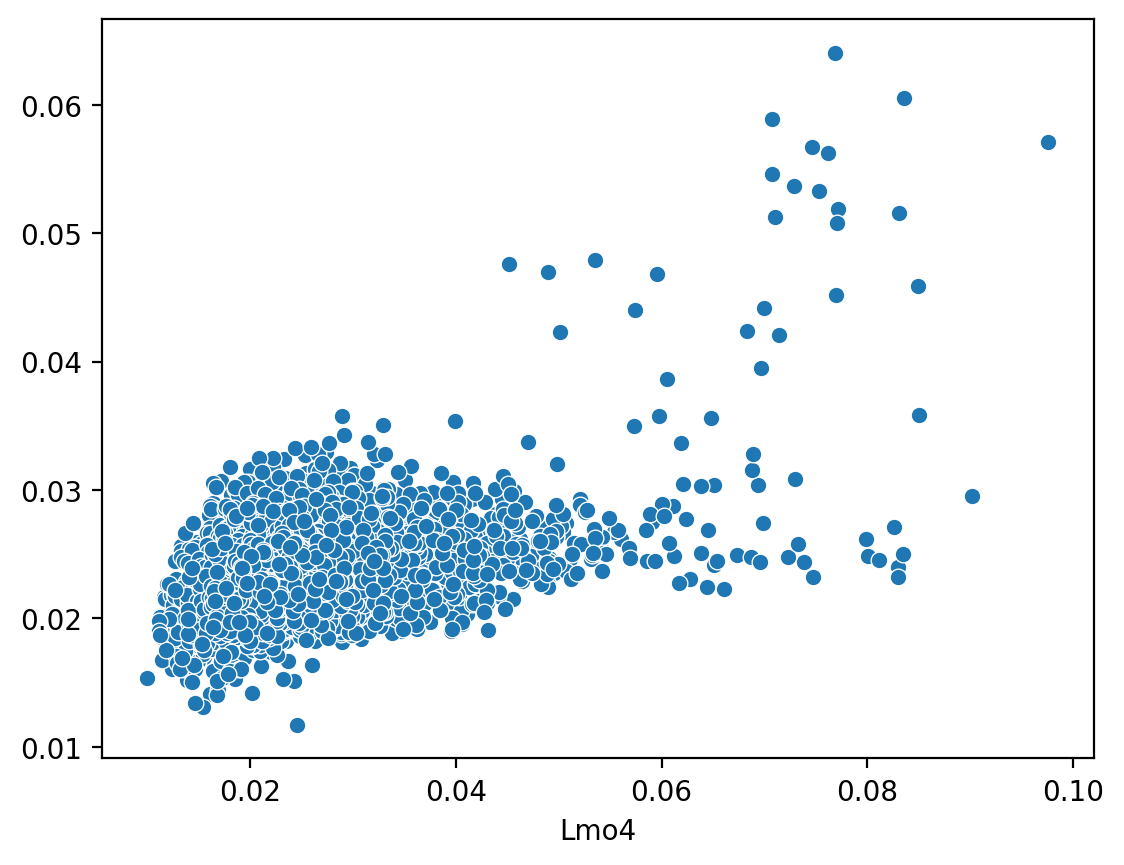

In [57]:
sns.scatterplot(y=y_pred, x=estimator.train_df['Lmo4'])
plt.show()

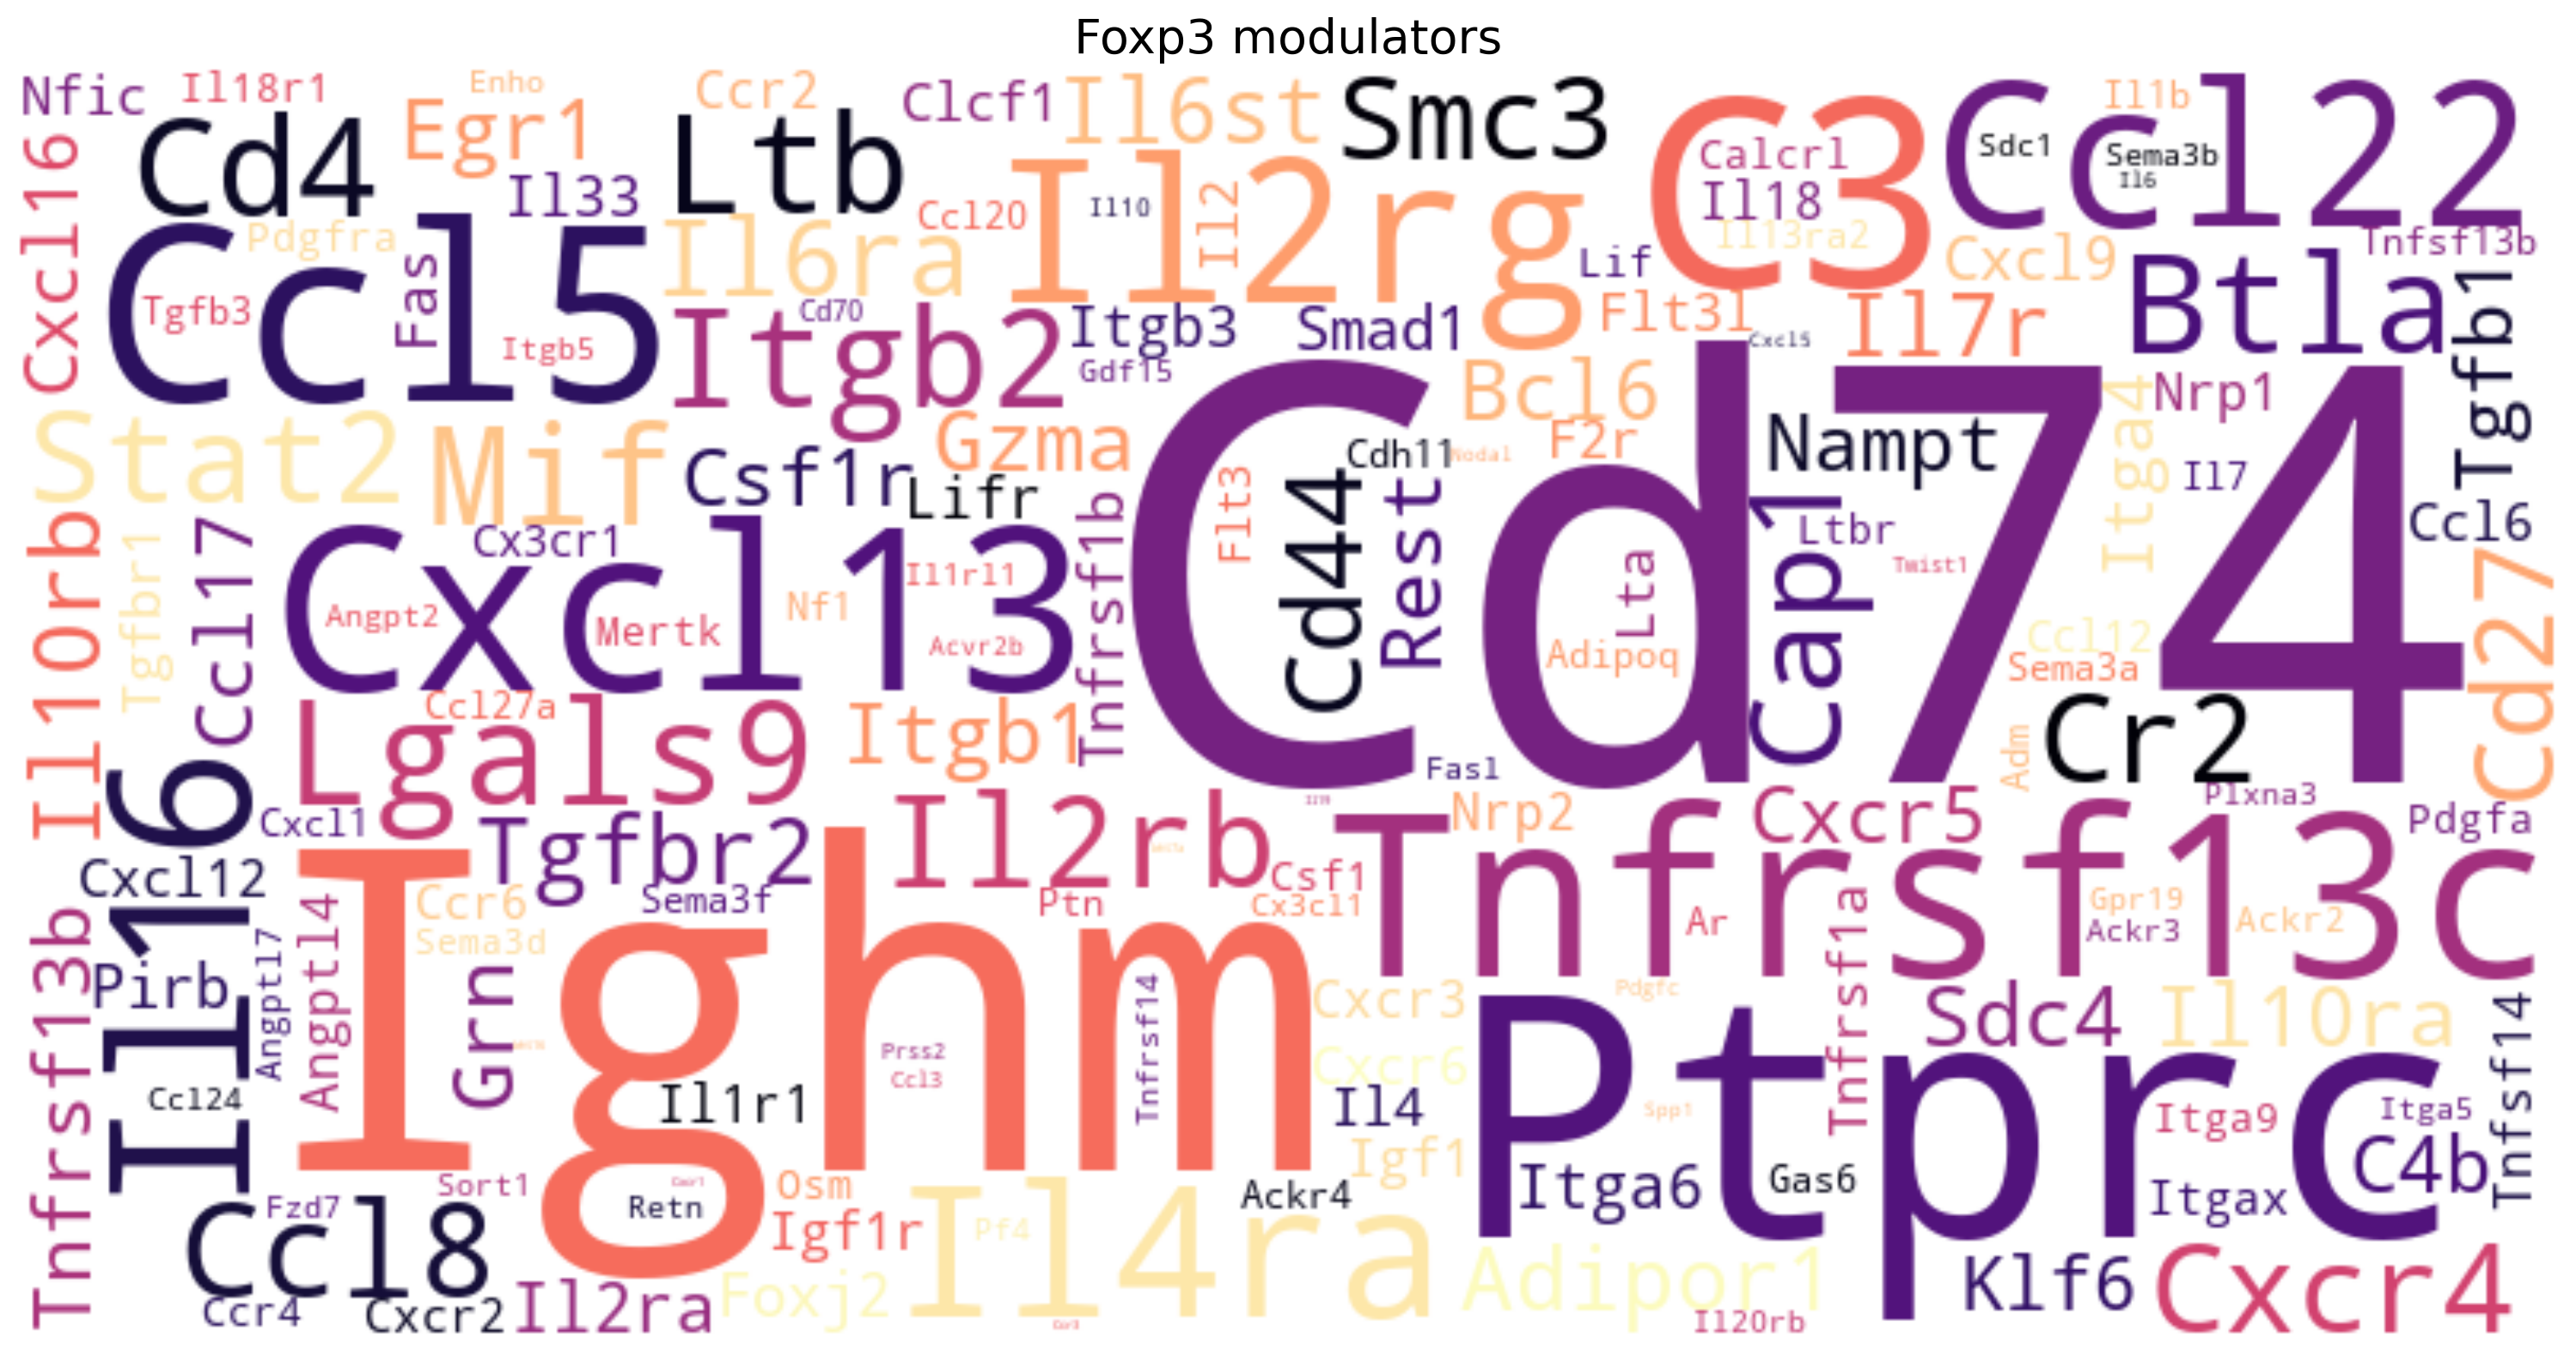

In [19]:
%matplotlib inline
estimator.plot_modulators(cmap='magma')

In [20]:
estimator.fit(num_epochs=1, learning_rate=5e-3)

Fitting Foxp3 with 169 modulators
	12 Transcription Factors
	131 Ligand-Receptor Pairs
	26 TranscriptionFactor-Ligand Pairs
0: -0.0742 | 0.2958
1: -2.0188 | 0.3736
2: -1.3595 | 0.4958
3: -3.9662 | 0.5557
4: -3.0252 | 0.2935
5: -2.1991 | 0.2116
6: -1.5058 | 0.1995


In [21]:
betadata = estimator.betadata

In [25]:
betadata[[i for i in betadata.columns if 'beta' in i]]

beta0   beta_Ar  beta_Bcl6  beta_Egr1  beta_Foxj2  \
AAAAAAAGCCAACA  0.001539  0.019648   0.000402   0.019150   -0.012115   
AAAAAACGGTAGAT  0.001353  0.016467   0.000431   0.015818   -0.009832   
AAAAAATCCGGCGA  0.004020  0.000075   0.001146  -0.000031    0.001869   
AAAAACCGTCAGAC  0.001391  0.017863   0.000405   0.016829   -0.010485   
AAAAACGCTCCGAC  0.001424  0.017926   0.000432   0.017018   -0.010651   
...                  ...       ...        ...        ...         ...   
TTTTTTGTACGATT  0.001543  0.020121   0.000408   0.019179   -0.011959   
TTTTTTTATGGTAC  0.001504  0.019756   0.000408   0.018725   -0.011744   
TTTTTTTGTCGCCT -0.000002 -0.001729   0.019045   0.000142    0.008218   
TTTTTTTTATTATA  0.001393  0.018052   0.000386   0.017076   -0.010668   
TTTTTTTTGCTTTA  0.001331  0.016186   0.000427   0.015511   -0.009621   

                beta_Klf6  beta_Nf1  beta_Nfic  beta_Rest  beta_Smad1  ...  \
AAAAAAAGCCAACA   0.006353  0.003878   0.000923   0.001869    0.014601  ...   
AAAAAACGGTAGAT   0.004881  0.003066   0.000843   0.001600    0.011310  ...   
AAAAAATCCGGCGA   0.006198  0.000021   0.000191   0.000708    0.000111  ...   
AAAAACCGTCAGAC   0.004987  0.003415   0.000857   0.001599    0.012331  ...   
AAAAACGCTCCGAC   0.005466  0.003537   0.000882   0.001692    0.012897  ...   
...                   ...       ...        ...        ...         ...  ...   
TTTTTTGTACGATT   0.006119  0.003876   0.000916   0.001806    0.014299  ...   
TTTTTTTATGGTAC   0.006033  0.003742   0.000908   0.001739    0.013936  ...   
TTTTTTTGTCGCCT   0.010590  0.014151   0.018759   0.004353    0.003862  ...   
TTTTTTTTATTATA   0.004924  0.003368   0.000854   0.001570    0.012421  ...   
TTTTTTTTGCTTTA   0.004684  0.002981   0.000831   0.001555    0.011010  ...   

                beta_Enho#Rest  beta_Il6#Smad1  beta_Il18#Smad1  \
AAAAAAAGCCAACA        0.000143    2.430738e-04        -0.009802   
AAAAAACGGTAGAT        0.000377    1.481917e-04        -0.011096   
AAAAAATCCGGCGA        0.000006    2.008704e-07        -0.000027   
AAAAACCGTCAGAC        0.000286    1.783186e-04        -0.009596   
AAAAACGCTCCGAC        0.000169    1.872206e-04        -0.010404   
...                        ...             ...              ...   
TTTTTTGTACGATT        0.000317    2.323545e-04        -0.009491   
TTTTTTTATGGTAC        0.000351    2.187422e-04        -0.009169   
TTTTTTTGTCGCCT        0.000108   -6.426514e-05         0.004169   
TTTTTTTTATTATA        0.000317    1.848855e-04        -0.008955   
TTTTTTTTGCTTTA        0.000379    1.414058e-04        -0.010919   

                beta_Tnfsf13b#Smad1  beta_Ccl12#Smad1  beta_Clcf1#Smc3  \
AAAAAAAGCCAACA             0.000042         -0.019659        -0.011353   
AAAAAACGGTAGAT             0.000011         -0.016599        -0.010842   
AAAAAATCCGGCGA            -0.000144         -0.000016        -0.000003   
AAAAACCGTCAGAC             0.000075         -0.017184        -0.010688   
AAAAACGCTCCGAC             0.000070         -0.017605        -0.010844   
...                             ...               ...              ...   
TTTTTTGTACGATT             0.000082         -0.019721        -0.011425   
TTTTTTTATGGTAC             0.000088         -0.019253        -0.011542   
TTTTTTTGTCGCCT            -0.000060          0.002024         0.004902   
TTTTTTTTATTATA             0.000079         -0.017349        -0.010669   
TTTTTTTTGCTTTA             0.000011         -0.016259        -0.010685   

                beta_Clcf1#Stat2  beta_Il10#Stat2  beta_Tgfb1#Twist1  \
AAAAAAAGCCAACA         -0.015345         0.002120          -0.000131   
AAAAAACGGTAGAT         -0.014171         0.002025          -0.000121   
AAAAAATCCGGCGA         -0.000288        -0.000175           0.000004   
AAAAACCGTCAGAC         -0.014507         0.002155          -0.000120   
AAAAACGCTCCGAC         -0.014799         0.001758          -0.000121   
...                          ...              ...                ...   
TTTTTTGTACGATT     

In [23]:
estimator.train_df

Foxp3        Ar      Bcl6      Egr1     Foxj2      Klf6  \
AAAAAAAGCCAACA  0.001721  0.011551  0.015360  0.012597  0.004367  0.009738   
AAAAAACGGTAGAT  0.001082  0.002033  0.023408  0.014989  0.007301  0.018051   
AAAAAATCCGGCGA  0.010355  0.005054  0.013550  0.053883  0.006111  0.018494   
AAAAACCGTCAGAC  0.000704  0.000408  0.018477  0.011174  0.010579  0.012860   
AAAAACGCTCCGAC  0.002275  0.001739  0.039854  0.020314  0.007485  0.014620   
...                  ...       ...       ...       ...       ...       ...   
TTTTTTGTACGATT  0.001968  0.000967  0.023101  0.017397  0.007044  0.010528   
TTTTTTTATGGTAC  0.002402  0.002417  0.013981  0.018489  0.009335  0.010510   
TTTTTTTGTCGCCT  0.001763  0.005670  0.013731  0.021745  0.005943  0.011560   
TTTTTTTTATTATA  0.001338  0.000485  0.015227  0.026586  0.009039  0.015632   
TTTTTTTTGCTTTA  0.000766  0.002367  0.017122  0.008497  0.008345  0.011323   

                     Nf1      Nfic      Rest     Smad1  ...  Enho#Rest  \
AAAAAAAGCCAACA  0.001814  0.002964  0.013205  0.004924  ...   0.000394   
AAAAAACGGTAGAT  0.001688  0.013184  0.018932  0.017047  ...   0.000240   
AAAAAATCCGGCGA  0.001750  0.002967  0.013344  0.007006  ...   0.000065   
AAAAACCGTCAGAC  0.001365  0.005086  0.020294  0.008220  ...   0.000677   
AAAAACGCTCCGAC  0.005011  0.004337  0.021374  0.008240  ...   0.000984   
...                  ...       ...       ...       ...  ...        ...   
TTTTTTGTACGATT  0.001228  0.008125  0.030525  0.008073  ...   0.000563   
TTTTTTTATGGTAC  0.000978  0.020891  0.011252  0.020038  ...   0.000341   
TTTTTTTGTCGCCT  0.000364  0.004109  0.009960  0.010341  ...   0.000100   
TTTTTTTTATTATA  0.004853  0.006010  0.018603  0.006688  ...   0.000434   
TTTTTTTTGCTTTA  0.001420  0.006193  0.040745  0.009153  ...   0.000550   

                Il6#Smad1  Il18#Smad1  Tnfsf13b#Smad1  Ccl12#Smad1  \
AAAAAAAGCCAACA   0.000026    0.000843        0.000213     0.000693   
AAAAAACGGTAGAT   0.000026    0.006792        0.001001     0.010025   
AAAAAATCCGGCGA   0.000051    0.000583        0.000285     0.000456   
AAAAACCGTCAGAC   0.000032    0.002404        0.000570     0.001601   
AAAAACGCTCCGAC   0.000152    0.001819        0.000568     0.001715   
...                   ...         ...             ...          ...   
TTTTTTGTACGATT   0.000041    0.001715        0.000450     0.001079   
TTTTTTTATGGTAC   0.000082    0.007453        0.001417     0.004366   
TTTTTTTGTCGCCT   0.000081    0.001561        0.000176     0.000734   
TTTTTTTTATTATA   0.000317    0.001993        0.000571     0.001192   
TTTTTTTTGCTTTA   0.000007    0.006361        0.000698     0.008970   

                Clcf1#Smc3  Clcf1#Stat2  Il10#Stat2  Tgfb1#Twist1  \
AAAAAAAGCCAACA    0.010076     0.015759    0.000174      0.000003   
AAAAAACGGTAGAT    0.006315     0.007942    0.000752      0.000186   
AAAAAATCCGGCGA    0.003110     0.002781    0.000160      0.000046   
AAAAACCGTCAGAC    0.030650     0.020574    0.000284      0.000373   
AAAAACGCTCCGAC    0.010199     0.011053    0.000268      0.000281   
...                    ...          ...         ...           ...   
TTTTTTGTACGATT    0.010690     0.009090    0.000270      0.000012   
TTTTTTTATGGTAC    0.003110     0.010087    0.000820      0.000059   
TTTTTTTGTCGCCT    0.003384     0.003223    0.000076      0.000054   
TTTTTTTTATTATA    0.010747     0.011533    0.000335      0.000020   
TTTTTTTTGCTTTA    0.012146     0.016548    0.001887      0.001242   

                 Igf1#Twist1  
AAAAAAAGCCAACA  7.137703e-07  
AAAAAACGGTAGAT  2.654871e-04  
AAAAAATCCGGCGA  1.811331e-05  
AAAAACCGTCAGAC  8.795536e-05  
AAAAACGCTCCGAC  7.164873e-05  
...                      ...  
TTTTTTGTACGATT  5.273149e-06  
TTTTTTTATGGTAC  6.803674e-05  
TTTTTTTGTCGCCT  2.540678e-05  
TTTTTTTTATTATA  7.140322e-06  
TTTTTTTTGCTTTA  2.621077e-03  

[15836 rows x 170 columns]

In [50]:
adata.to_df(layer='normalized_count')[adata.obs.cell_type == 'B-cell'][
    np.unique(estimator.receptors)].mean().sort_values(ascending=False)

Cd74         0.878205
Ighm         0.466637
Ptprc        0.175377
Tnfrsf13c    0.127490
Il21r        0.089831
               ...   
Fzd10        0.000000
Chrna5       0.000000
Sstr3        0.000000
Chrng        0.000000
Chrna1       0.000000
Length: 210, dtype: float32

In [82]:
adata.to_df(layer='normalized_count').join(adata.obs.cell_type).groupby('cell_type').mean()[
    np.unique(estimator.receptors)].T.loc[['Il2ra', 'Cxcr4', 'Cxcr5', 'Il21r']]

cell_type    B-cell  Cd8 T-cell       Th2  Resting T-cell       Tfh      Treg  \
Il2ra      0.004083    0.012403  0.033336        0.005862  0.013932  0.046951   
Cxcr4      0.041578    0.026619  0.021212        0.012957  0.031951  0.023913   
Cxcr5      0.021891    0.006752  0.006757        0.000398  0.008703  0.003792   
Il21r      0.089831    0.095633  0.083565        0.084297  0.088875  0.068960   

cell_type        NK  
Il2ra      0.020475  
Cxcr4      0.031377  
Cxcr5      0.008154  
Il21r      0.075117

In [ ]:
estimator.train_df

In [79]:
pd.DataFrame(
    estimator.models[0].anchors[1:].cpu().numpy(), 
    index=estimator.train_df.columns[1:]
).sort_values(by=0, ascending=False)

0
Il17a$Il17ra        2.132991
Il13$Il4ra          1.992557
Nr1h4               1.477392
Cd40lg$Itgb2        1.421578
Tnfsf13b$Tnfrsf13b  1.372255
...                      ...
Il18$Il18r1        -1.331378
Il4$Il13ra2        -1.410662
Nampt$Itga5        -1.502363
Ccl6$Ccr2          -1.684606
Vegfa$Kdr          -1.935093

[647 rows x 1 columns]

In [59]:
betadata = estimator.betadata

In [60]:
beta_cols = [i for i in betadata.columns if 'beta_' in i]

In [61]:
betadata[beta_cols].mean().sort_values(ascending=False)

beta_PATZ1           0.335779
beta_FOXP1           0.286179
beta_THAP1           0.271335
beta_TCF7L2          0.186623
beta_GLIS3           0.172774
                       ...   
beta_BHLHE40        -0.067158
beta_CSF1$CSF1R     -0.070296
beta_CLCF1$LIFR     -0.083664
beta_ZNF263         -0.105564
beta_CXCL12$ACKR3   -0.141769
Length: 163, dtype: float32

In [39]:
from spaceoracle.prophets import Prophet
import anndata as ad
import pandas as pd
import matplotlib

In [70]:
betadata.to_parquet(f'/tmp/models/{estimator.target_gene}_betadata.parquet')

In [43]:
!mkdir /tmp/models

In [90]:
fs = filesystem(
    'sftp', 
    host='htc.crc.pitt.edu', 
    username='kor11', 
    password=get_exports_from_zshrc()['HTCRC_PASSWORD']
)

with fs.open('/ix/djishnu/shared/djishnu_kor11/super_filtered_runs/mLDN3-1_v4/Pax5_betadata.parquet') as f:
    df_ssh = pd.read_parquet(f)

In [91]:
df_ssh.to_parquet(f'/tmp/models/Pax5_betadata.parquet')

In [155]:
import glob
from tqdm import tqdm

In [156]:
all_pairs = set()
paths = list(glob.glob('/Volumes/SSD/mLDN3-1_v4/*_betadata.parquet'))
for x in tqdm(paths):
    for pairs in [i for i in pd.read_parquet(x).columns if '#' in i]:
        all_pairs.add(pairs)



100%|██████████| 2859/2859 [01:12<00:00, 39.48it/s]


In [158]:
all_pairs = list(all_pairs)

In [160]:
all_pairs

['beta_Gas6#Prox1',
 'beta_Il1b#Nfe2l2',
 'beta_Tgfb1#Tbx3',
 'beta_Gas6#Creb3l1',
 'beta_Il18#Rel',
 'beta_Il4#Stat2',
 'beta_Ptn#Hesx1',
 'beta_Tgfb1#Osr1',
 'beta_Il4#Erg',
 'beta_Adm#Npas1',
 'beta_Clcf1#Hoxa2',
 'beta_Clcf1#Mef2c',
 'beta_Il10#Klf4',
 'beta_Tgfb1#Fli1',
 'beta_Lta#Dmrt2',
 'beta_Ltb#Gli3',
 'beta_Nodal#Zfhx3',
 'beta_Retn#Nfe2l2',
 'beta_Tnfsf13b#Hesx1',
 'beta_Osm#Zfhx3',
 'beta_Osm#Dmrt2',
 'beta_Il10#Foxp3',
 'beta_Osm#Runx1',
 'beta_Tnfsf13b#Id1',
 'beta_Il2#Egr2',
 'beta_Retn#Sox11',
 'beta_Cxcl12#Zbtb4',
 'beta_Enho#Sox11',
 'beta_Nodal#Elk3',
 'beta_Tgfb1#Hoxd10',
 'beta_Tgfb1#Ar',
 'beta_Enho#Nr1d2',
 'beta_Cx3cl1#Hesx1',
 'beta_Il18#Relb',
 'beta_Il10#Erg',
 'beta_Nampt#Ezh2',
 'beta_Osm#Sox11',
 'beta_Il18#Creb3l2',
 'beta_Prss2#Nfic',
 'beta_Il1b#Atf3',
 'beta_Il4#Tbx21',
 'beta_Osm#Ebf1',
 'beta_Angptl4#Fosb',
 'beta_Cxcl12#Snai2',
 'beta_Tgfb3#Id2',
 'beta_Clcf1#Hltf',
 'beta_Il7#Klf4',
 'beta_Osm#Ezh2',
 'beta_Clcf1#Erg',
 'beta_Ccl12#Cebpa',
 'beta_

In [171]:
[i.split('#')[1] for i in all_pairs if 'Il4' in i]


['Stat2',
 'Erg',
 'Tbx21',
 'Runx1',
 'Egr2',
 'Nfic',
 'Esrra',
 'Itgb2',
 'Nfe2l2',
 'Prdm1',
 'Cebpa',
 'Twist1',
 'Fli1',
 'Hoxa2',
 'Creb3l2',
 'Tcf4',
 'Mafb']

In [122]:
nichenet_lt = pd.read_parquet('/Users/koush/Projects/SpaceOracle/data/ligand_target_mouse.parquet')

In [128]:
nichenet_lt = nichenet_lt.loc[np.intersect1d(nichenet_lt.index, adata.var_names)][np.intersect1d(nichenet_lt.columns, adata.var_names)]

In [168]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata=adata,
    target_gene='Il4',
    layer='imputed_count',
    cluster_annot='cell_type_int', 
    grn=co_grn,
    radius=100
)

In [169]:
estimator.regulators

['Ar',
 'Atf3',
 'Bclaf1',
 'Creb3',
 'E2f5',
 'Ebf1',
 'Egr1',
 'Elf1',
 'Fos',
 'Fosb',
 'Foxp3',
 'Hdac2',
 'Irf6',
 'Irf9',
 'Jdp2',
 'Jun',
 'Klf12',
 'Klf4',
 'Klf6',
 'Mef2c',
 'Myef2',
 'Nr1h4',
 'Pax5',
 'Pbx3',
 'Prox1',
 'Rest',
 'Rorc',
 'Rreb1',
 'Rxra',
 'Smad1',
 'Smc3',
 'Snai2',
 'Spi1']

In [137]:
#ligands
nichenet_lt['Ccl5']

Aaas       0.004466
Aamdc      0.002916
Aatk       0.002758
Abca7      0.002692
Abcc1      0.004284
             ...   
Zmym5      0.002245
Zscan30    0.001756
Zswim5     0.001824
Zwilch     0.002837
Zzef1      0.003322
Name: Ccl5, Length: 2936, dtype: float32

In [141]:
nichenet_lt['Ccl5'].sort_values(ascending=False)[:10]

Il6       0.072890
Ccl12     0.069603
Il1b      0.069238
Cd44      0.064493
Il4       0.063786
Itgb2     0.063774
Xcl1      0.063745
Cxcr3     0.062855
Ldlr      0.062494
Cdkn1a    0.020666
Name: Ccl5, dtype: float32

In [92]:
pythia = Prophet(
    adata=estimator.adata,
    models_dir='/tmp/models',
    annot='cell_type_int',
    annot_labels='cell_type'
)

In [94]:
gex_df = estimator.adata.to_df(layer=estimator.layer)
pythia.compute_betas()
gene_mtx = pythia.adata.layers['imputed_count']
weighted_ligands = pythia._compute_weighted_ligands(gene_mtx)
beta_dict = pythia._get_wbetas_dict(
    pythia.beta_dict, weighted_ligands, gene_mtx)
wbetas = beta_dict.data['Pax5'].wbetas
xy = beta_dict.xydf.copy()
xy.columns = ['x', 'y']
df = wbetas \
        .join(estimator.adata.obs) \
        .join(xy) \
        .join(gex_df)

100%|██████████| 1/1 [00:00<00:00, 65.15it/s]


In [97]:
beta_cols = [i for i in betadata.columns if 'beta_']

In [115]:
[i for i in beta_cols if 'Egr1' in i]

['beta_Egr1', 'beta_Il10#Egr1']

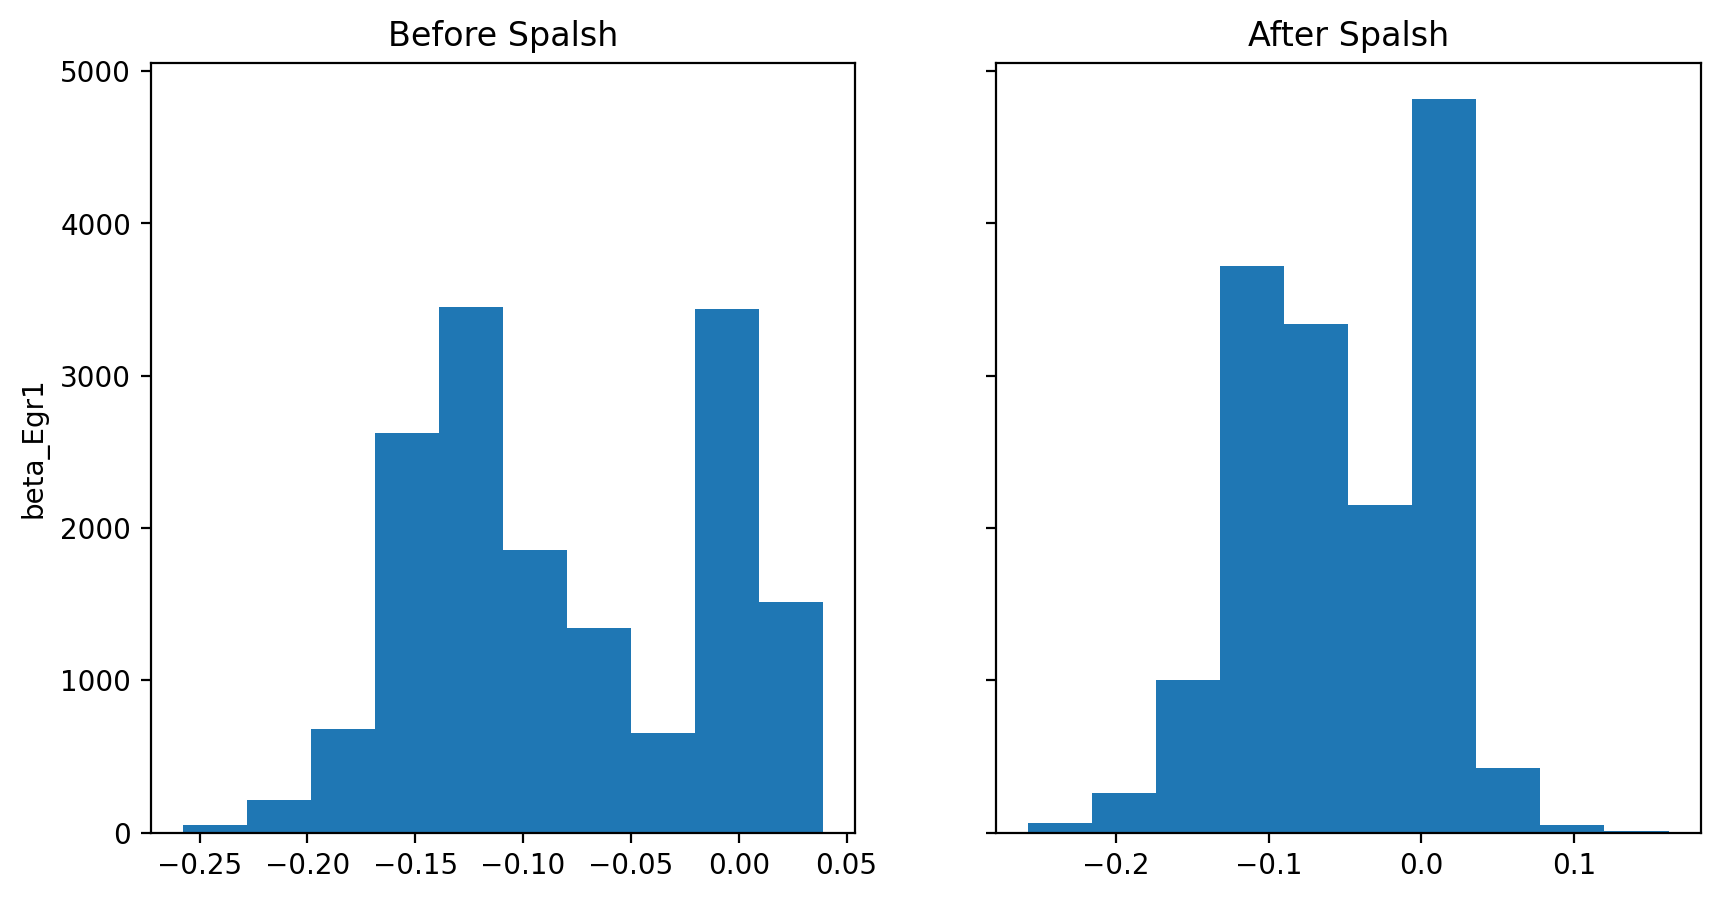

In [110]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
beta = 'beta_Egr1'
pythia.beta_dict.data['Pax5'][beta].plot.hist(ax=ax[0])
wbetas[beta].plot.hist(ax=ax[1])
ax[0].set_title('Before Spalsh')
ax[1].set_title('After Spalsh')
ax[0].set_ylabel(f'{beta}')
plt.show()

In [111]:
pythia.adata.to_df(layer='imputed_count')[['Egr1', 'Pax5']].join(pythia.adata.obs.cell_type).groupby('cell_type').mean()

Egr1      Pax5
cell_type                         
B-cell          0.017184  0.075197
Cd8 T-cell      0.030936  0.020631
Th2             0.035243  0.022309
Resting T-cell  0.031273  0.017702
Tfh             0.030445  0.026672
Treg            0.030713  0.020147
NK              0.027831  0.017231

<Axes: xlabel='Egr1', ylabel='Pax5'>

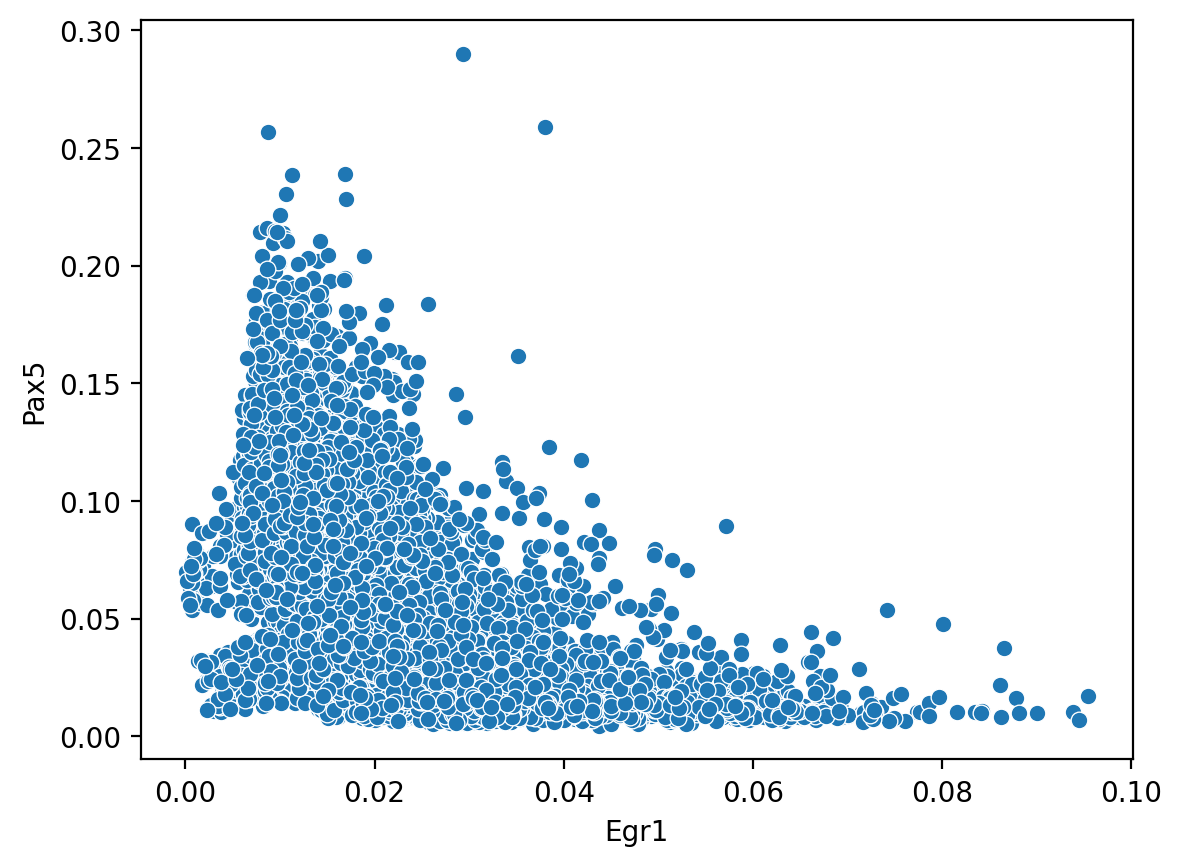

In [112]:
sns.scatterplot(data=adata.to_df(layer='imputed_count'), x='Egr1', y='Pax5')

In [50]:
betadata[beta_cols].mean().sort_values(ascending=False)

beta_Pf4$Cxcr3        2.193610
beta_Ccl20$Ccr6       1.522170
beta_Il10$Il10ra      1.236284
beta_Il10$Il10rb      1.137999
beta_Adm$Calcrl       0.801827
                        ...   
beta_Enho$Gpr19      -1.623874
beta_Il33$Il1rl1     -1.634099
beta_Cx3cl1$Cx3cr1   -2.233999
beta_Il7$Il7r        -2.260836
beta_Cd70$Cd27       -2.999190
Length: 131, dtype: float32

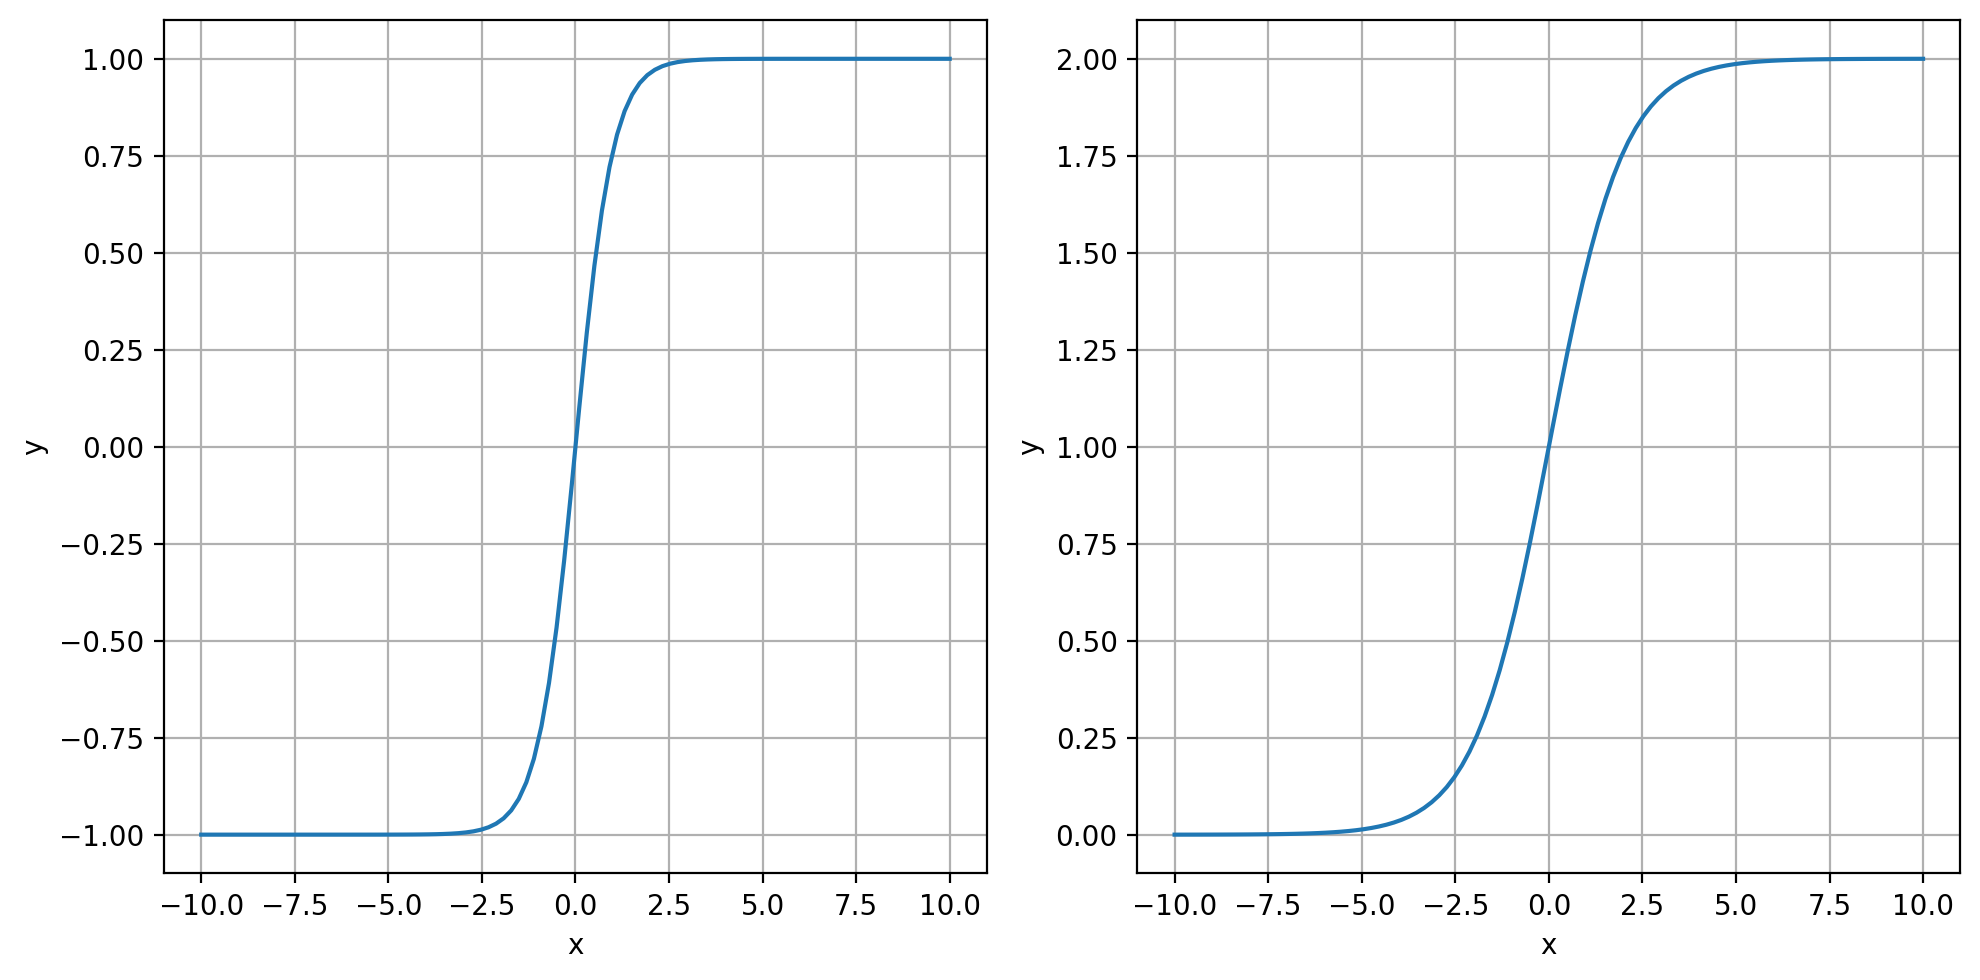

In [82]:
import torch 
import torch.nn.functional as F

x = torch.linspace(-10, 10, 100)
y1 = torch.tanh(x)
y2 = torch.sigmoid(x) * 2

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x.numpy(), y1.numpy())
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122) 
plt.plot(x.numpy(), y2.numpy())
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [ ]:
import duckdb
from fsspec import filesystem
import os

def get_exports_from_zshrc():
    """Load .zshrc file and extract all export statements"""
    try:
        with open(os.path.expanduser('~/.zshrc'), 'r') as f:
            zshrc = f.read()
            
        # Find all export statements
        exports = {}
        for line in zshrc.split('\n'):
            line = line.strip()
            if line.startswith('export'):
                # Remove 'export' and split into key/value
                key_val = line.replace('export', '').strip()
                if '=' in key_val:
                    key, val = key_val.split('=', 1)
                    # Remove quotes if present
                    val = val.strip('"\'')
                    exports[key.strip()] = val

        return exports
    except:
        return {}

# fs = filesystem(
#     'sftp', 
#     host='htc.crc.pitt.edu', 
#     username='kor11', 
#     password=get_exports_from_zshrc()['HTCRC_PASSWORD']
# )

# with fs.open('/ix/djishnu/shared/djishnu_kor11/super_filtered_runs/mLDN3-1_v4/H2-Ab1_betadata.parquet') as f:
#     df_ssh = pd.read_parquet(f)